## Prediciendo categorías en base a títulos

**Objetivo:**
    
Replicar sistema categorizador de productos de Mercado Libre, utilizando redes neuronales recurrentes.

**¿Por qué es importante un sistema así en un e-commerce?**

- Mejor sistema de búsqueda.
- Mayor confianza del usuario (permite completar mas atributos del producto de manera automática).
- Sistemas de recomendación más eficientes.
- Tomar acciones sobre una agrupación determinada de productos.

<img src="images/meli_vender.png" alt="drawing" width="700"/>

### Categorizador de dominios de Mercado Libre

**Documentación API Mercado Libre:**
    
https://developers.mercadolibre.com.ar/es_ar/categorias-y-atributos#Categorias

In [42]:
import http.client
from urllib.parse import quote_plus

In [43]:
conn = http.client.HTTPSConnection("api.mercadolibre.com")

In [45]:
title = "celular samsung j6"

conn.request("GET", f"/sites/MLA/domain_discovery/search?q=${quote_plus(title)}")
res = conn.getresponse()
data = res.read()
print(data.decode("utf-8"))

[{"domain_id":"MLA-CELLPHONES","domain_name":"Celulares","category_id":"MLA1055","category_name":"Celulares y Smartphones","attributes":[{"id":"BRAND","name":"Marca","value_id":"206","value_name":"Samsung"},{"id":"LINE","name":"Línea","value_id":"195973","value_name":"Galaxy J"},{"id":"MODEL","name":"Modelo","value_id":"389521","value_name":"J6"},{"id":"IS_DUAL_SIM","name":"Es Dual SIM","value_id":"242084","value_name":"No"}]}]


## Generemos nuestro dataset

In [46]:
import pandas as pd
import json

In [47]:
conn.request("GET", "/sites/MLA/categories")
res = conn.getresponse()
data = res.read()
print(data.decode("utf-8"))

[{"id":"MLA5725","name":"Accesorios para Vehículos"},{"id":"MLA1512","name":"Agro"},{"id":"MLA1403","name":"Alimentos y Bebidas"},{"id":"MLA1071","name":"Animales y Mascotas"},{"id":"MLA1367","name":"Antigüedades y Colecciones"},{"id":"MLA1368","name":"Arte, Librería y Mercería"},{"id":"MLA1743","name":"Autos, Motos y Otros"},{"id":"MLA1384","name":"Bebés"},{"id":"MLA1246","name":"Belleza y Cuidado Personal"},{"id":"MLA1039","name":"Cámaras y Accesorios"},{"id":"MLA1051","name":"Celulares y Teléfonos"},{"id":"MLA1648","name":"Computación"},{"id":"MLA1144","name":"Consolas y Videojuegos"},{"id":"MLA1500","name":"Construcción"},{"id":"MLA1276","name":"Deportes y Fitness"},{"id":"MLA5726","name":"Electrodomésticos y Aires Ac."},{"id":"MLA1000","name":"Electrónica, Audio y Video"},{"id":"MLA2547","name":"Entradas para Eventos"},{"id":"MLA407134","name":"Herramientas"},{"id":"MLA1574","name":"Hogar, Muebles y Jardín"},{"id":"MLA1499","name":"Industrias y Oficinas"},{"id":"MLA1459","name":"I

In [48]:
pd.DataFrame(json.loads(data.decode("utf-8")))

id                           name
0     MLA5725      Accesorios para Vehículos
1     MLA1512                           Agro
2     MLA1403            Alimentos y Bebidas
3     MLA1071            Animales y Mascotas
4     MLA1367     Antigüedades y Colecciones
5     MLA1368      Arte, Librería y Mercería
6     MLA1743           Autos, Motos y Otros
7     MLA1384                          Bebés
8     MLA1246     Belleza y Cuidado Personal
9     MLA1039           Cámaras y Accesorios
10    MLA1051          Celulares y Teléfonos
11    MLA1648                    Computación
12    MLA1144         Consolas y Videojuegos
13    MLA1500                   Construcción
14    MLA1276             Deportes y Fitness
15    MLA5726  Electrodomésticos y Aires Ac.
16    MLA1000     Electrónica, Audio y Video
17    MLA2547          Entradas para Eventos
18  MLA407134                   Herramientas
19    MLA1574        Hogar, Muebles y Jardín
20    MLA1499          Industrias y Oficinas
21    MLA1459                      Inmuebles
22    MLA1182         Instrumentos Musicales
23    MLA3937                Joyas y Relojes
24    MLA1132              Juegos y Juguetes
25    MLA3025      Libros, Revistas y Comics
26    MLA1168     Música, Películas y Series
27    MLA1430              Ropa y Accesorios
28  MLA409431    Salud y Equipamiento Médico
29    MLA1540                      Servicios
30    MLA9304  Souvenirs, Cotillón y Fiestas
31    MLA1953               Otras categorías

In [49]:
from config import AppCfg

cfg = AppCfg()

class MeliGet:
    """
    Clase basica con fines de demostracion de uso.
    No recomendado para fines de obtener performance.
    """
    
    def __init__(self, cfg):
        self.conn = http.client.HTTPSConnection("api.mercadolibre.com")
        self.payload = ''
        self.headers = {
            'Bearer': cfg.ACCESS_TOKEN
        }
        
    def search_by_category(self, category_id, offset):
        try:
            self.conn.request(
                "GET", 
                f"/sites/MLA/search?category={category_id}&offset={offset}", 
                self.payload, 
                self.headers
            )
            res = self.conn.getresponse()
            data = res.read()
            df = pd.DataFrame(json.loads(data.decode("utf-8"))['results'])
        except:
            # print("DataFrame vacio.")
            df = pd.DataFrame([])
        return df
        
    def append_offset(self, category_id, n_offset):
        dfs = [self.search_by_category(category_id, offset) for offset in range(1, n_offset+1)]
        dfs = pd.concat(dfs).reset_index(drop=True)
        return dfs
    
    def build_dataset(self, category_list, n_offset):
        dfs = [self.append_offset(category_id, n_offset) for category_id in category_list]
        dfs = pd.concat(dfs).reset_index(drop=True)
        return dfs
        

In [52]:
meli = MeliGet(cfg)

In [53]:
tmp_df = meli.search_by_category('MLA1055', 1)

In [54]:
tmp_df.head(2)

id site_id                                              title  \
0   MLA918474630     MLA  Samsung Galaxy A32 128 Gb  Awesome Black 4 Gb Ram   
1  MLA1137712864     MLA  Samsung Galaxy S20 Fe 5g 128 Gb  Cloud Navy 6 ...   

                                              seller   price  \
0  {'id': 608846165, 'permalink': 'http://perfil....   65999   
1  {'id': 608846165, 'permalink': 'http://perfil....  127999   

                                              prices sale_price currency_id  \
0  {'id': 'MLA918474630', 'prices': [{'id': '357'...       None         ARS   
1  {'id': 'MLA1137712864', 'prices': [{'id': '48'...       None         ARS   

   available_quantity  sold_quantity  ...  \
0                 182          16701  ...   
1                 616           2578  ...   

                                                tags catalog_listing  \
0  [deal_of_the_day, extended_warranty_eligible, ...            True   
1  [9x_campaign, deal_of_the_day, extended_warran...            True   

  use_thumbnail_id offer_score offer_share match_score winner_item_id  \
0             True        None        None        None           None   
1             True        None        None        None           None   

   melicoin discounts order_backend  
0      None      None             1  
1      None      None             2  

[2 rows x 39 columns]

In [14]:
tmp_df.shape

(50, 39)

In [58]:
df = meli.build_dataset(['MLA1055', 'MLA1000', 'MLA1743', ], 50)

In [59]:
df.shape

(7500, 41)

In [60]:
df = df[['id', 'site_id', 'title', 'category_id', 'domain_id']]

In [61]:
df.to_csv('items_meli.csv', sep="␗", index=False)

In [65]:
# df.sample(30)

### Read & clean data

In [66]:
import pandas as pd
import dask.dataframe as dd
from preprocessing import dask_proc

In [67]:
# !pip install textacy
# !dask_procinstall "dask[complete]"

In [68]:
df = pd.read_csv('items_meli.csv', sep="␗", engine='python')

In [69]:
df.head(3)

id site_id                                              title  \
0   MLA918474630     MLA  Samsung Galaxy A32 128 Gb  Awesome Black 4 Gb Ram   
1  MLA1137712864     MLA  Samsung Galaxy S20 Fe 5g 128 Gb  Cloud Navy 6 ...   
2  MLA1142662789     MLA         Konka Indus Dual Sim 32 Gb  Negro 3 Gb Ram   

  category_id       domain_id  
0     MLA1055  MLA-CELLPHONES  
1     MLA1055  MLA-CELLPHONES  
2     MLA1055  MLA-CELLPHONES

In [70]:
tmp = dd.from_pandas(df, npartitions=5)

# Nombre de columna a preprocesar
title = 'title'

tmp = tmp.assign(title=tmp.map_partitions(dask_proc, title, meta='str')).compute(scheduler='processes')
tmp.title = tmp.title.astype('U')

In [71]:
df = tmp.copy()
del tmp

In [72]:
df.domain_id.nunique()

11

In [74]:
df.sample(20)

id site_id  \
377   MLA1137213701     MLA   
4205  MLA1150461708     MLA   
2330  MLA1135207985     MLA   
4702  MLA1130555204     MLA   
4962  MLA1146161249     MLA   
5291  MLA1151461314     MLA   
4410  MLA1147914362     MLA   
5880  MLA1151563737     MLA   
2082  MLA1146206805     MLA   
250   MLA1138459617     MLA   
5122  MLA1149377195     MLA   
7399  MLA1151458576     MLA   
749   MLA1145088043     MLA   
5806  MLA1150608077     MLA   
2184  MLA1149683072     MLA   
4394  MLA1149185944     MLA   
2681  MLA1112789911     MLA   
7192  MLA1151593410     MLA   
3257   MLA919622527     MLA   
1313  MLA1120890965     MLA   

                                                  title category_id  \
377         motorola edge 20 lite 128 gb verde 6 gb ram     MLA1055   
4205         smart tv tcl l40s66e 40 full hd android tv     MLA1002   
2330  celular samsung galaxy a23 128gb   4gb ram 90h...     MLA1055   
4702  auriculares in ear inalambricos noga twins ng ...     MLA3697   
4962          smart tv tcl l50p615 50 4k uhd android tv     MLA1002   
5291  fiat pulse 0km 2022 financiado tomo argo mobi ...     MLA1744   
4410  smart tv 32 philips android hd 32phd6917 77 11...     MLA1002   
5880  fiat pulse 0km 2022 financiado tomo argo mobi ...     MLA1744   
2082  xiaomi mi 11 lite 5g ne dual sim 128 gb azul c...     MLA1055   
250   samsung galaxy a33 5g 128 gb awesome black 6 g...     MLA1055   
5122         mitsubishi 2016 outlander 2 0 glx 2wd l 16     MLA1744   
7399  peugeot 208 allure automatico tip 0km 2022 ent...     MLA1744   
749            noblex a50 dual sim 32 gb negro 1 gb ram     MLA1055   
5806                chevrolet 2018 cruze 1 4 4 ptas ltz     MLA1744   
2184  motorola edge 30 pro 256 gb verde cosmos 12 gb...     MLA1055   
4394  roku se 3930se estandar full hd 32mb blanco y ...   MLA352001   
2681  soporte shirka sk 481 de pared para tv monitor...    MLA41925   
7192       vw taos highline automatica 0km 2022 ugarcia     MLA1744   
3257  soporte electroland sop 14 55 de pared para tv...    MLA41925   
1313  samsung galaxy a52s 5g 128 gb awesome black 6 ...     MLA1055   

                        domain_id  
377                MLA-CELLPHONES  
4205              MLA-TELEVISIONS  
2330               MLA-CELLPHONES  
4702               MLA-HEADPHONES  
4962              MLA-TELEVISIONS  
5291            MLA-CARS_AND_VANS  
4410              MLA-TELEVISIONS  
5880            MLA-CARS_AND_VANS  
2082               MLA-CELLPHONES  
250                MLA-CELLPHONES  
5122            MLA-CARS_AND_VANS  
7399            MLA-CARS_AND_VANS  
749                MLA-CELLPHONES  
5806            MLA-CARS_AND_VANS  
2184               MLA-CELLPHONES  
4394  MLA-STREAMING_MEDIA_DEVICES  
2681    MLA-TV_AND_MONITOR_MOUNTS  
7192            MLA-CARS_AND_VANS  
3257    MLA-TV_AND_MONITOR_MOUNTS  
1313               MLA-CELLPHONES

In [75]:
df.to_csv('items_meli_proc.csv', sep="␗", index=False)

### Labeling functions

In [76]:
import pandas as pd

In [77]:
# !pip install snorkel
# !pip install networkx==2.5.0

In [78]:
df = pd.read_csv('items_meli_proc.csv', sep="␗", engine='python')

In [79]:
df = df[df.domain_id.isin(['MLA-CELLPHONES', 'MLA-CELL_BATTERIES', 'MLA-SPEAKERS', 'MLA-HEADPHONES'])].reset_index(drop=True)

In [80]:
import re
from snorkel.labeling import labeling_function, PandasLFApplier

In [81]:
CELLPHONES = 0
CELL_BATTERIES = 1
SPEAKERS = 2
ABSTAIN = -1

In [89]:
df.sample(20)

id site_id  \
2486  MLA1151002596     MLA   
2461   MLA918326691     MLA   
3090  MLA1132263997     MLA   
666   MLA1132584768     MLA   
2998  MLA1132263997     MLA   
2008  MLA1150922023     MLA   
3430  MLA1115022466     MLA   
2013  MLA1130806055     MLA   
2007   MLA925745708     MLA   
860   MLA1133492016     MLA   
1612  MLA1145733121     MLA   
1345  MLA1136887304     MLA   
2655   MLA841085340     MLA   
1930  MLA1135129886     MLA   
2670  MLA1123497729     MLA   
2416   MLA911326928     MLA   
2710  MLA1123497729     MLA   
3447  MLA1147470283     MLA   
1469  MLA1150922023     MLA   
3101  MLA1145019721     MLA   

                                                  title category_id  \
2486              motorola edge 30 128 gb gris 8 gb ram     MLA1055   
2461    sansei s191 dual sim 3 mb negro y rojo 4 mb ram     MLA1055   
3090   pila 9v energizer max 522 rectangular   1 unidad     MLA6384   
666                samsung galaxy s21 fe gris oscuro 5g     MLA1055   
2998   pila 9v energizer max 522 rectangular   1 unidad     MLA6384   
2008                       tcl l7  32 gb negro 2 gb ram     MLA1055   
3430  auriculares in ear inalambricos samsung galaxy...     MLA3697   
2013                     samsung galaxy a03 4gb   128gb     MLA1055   
2007  xiaomi redmi 9a dual sim 32 gb azul celeste 2 ...     MLA1055   
860                tcl 20 se 256 gb nuit black 6 gb ram     MLA1055   
1612  samsung galaxy z flip3 5g 128 gb phantom black...     MLA1055   
1345  celular samsung galaxy s20fe 4g 128gb   6gb ra...     MLA1055   
2655       auriculares inalambricos sony wh ch510 negro     MLA3697   
1930  celular samsung galaxy a13 128gb   4gb ram pls...     MLA1055   
2670  auriculares in ear gamer inalambricos haylou g...     MLA3697   
2416  xiaomi redmi 9c dual sim 64 gb naranja amanece...     MLA1055   
2710  auriculares in ear gamer inalambricos haylou g...     MLA3697   
3447                 auriculares in ear jbl c50hi negro     MLA3697   
1469                       tcl l7  32 gb negro 2 gb ram     MLA1055   
3101        auriculares in ear inalambricos f9 5 blanco     MLA3697   

               domain_id  
2486      MLA-CELLPHONES  
2461      MLA-CELLPHONES  
3090  MLA-CELL_BATTERIES  
666       MLA-CELLPHONES  
2998  MLA-CELL_BATTERIES  
2008      MLA-CELLPHONES  
3430      MLA-HEADPHONES  
2013      MLA-CELLPHONES  
2007      MLA-CELLPHONES  
860       MLA-CELLPHONES  
1612      MLA-CELLPHONES  
1345      MLA-CELLPHONES  
2655      MLA-HEADPHONES  
1930      MLA-CELLPHONES  
2670      MLA-HEADPHONES  
2416      MLA-CELLPHONES  
2710      MLA-HEADPHONES  
3447      MLA-HEADPHONES  
1469      MLA-CELLPHONES  
3101      MLA-HEADPHONES

In [103]:
@labeling_function()
def is_cellphone(x):
    return CELLPHONES if re.search(r"samsung|ram|dual sim|celular", x.title) else ABSTAIN

@labeling_function()
def is_cell_batteries(x):
    return CELL_BATTERIES if re.search(r"pila", x.title) else ABSTAIN

@labeling_function()
def is_speakers(x):
    return SPEAKERS if re.search(r"parlante", x.title) else ABSTAIN



In [104]:
lfs = [is_cellphone, is_cell_batteries, is_speakers]

In [105]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df[['title']])

100%|████████████████████████████████████████████████████████| 3568/3568 [00:00<00:00, 12128.67it/s]


In [106]:
from snorkel.labeling import LFAnalysis


In [107]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()


j Polarity  Coverage  Overlaps  Conflicts
is_cellphone       0      [0]  0.674608       0.0        0.0
is_cell_batteries  1      [1]  0.052130       0.0        0.0
is_speakers        2      [2]  0.052691       0.0        0.0

In [108]:
from snorkel.labeling.model import LabelModel

In [109]:
label_model = LabelModel(cardinality=3, verbose=True)
label_model.fit(L_train, seed=123, lr=0.01, log_freq=10, n_epochs=100)

In [110]:
label_model.cardinality

3

In [111]:
df["labels"] = label_model.predict(L_train)


In [101]:
df.head(2)

id site_id                                    title category_id  \
0   MLA915976815     MLA  samsung galaxy a02 32 gb negro 2 gb ram     MLA1055   
1  MLA1105441801     MLA   samsung galaxy a12 64 gb azul 4 gb ram     MLA1055   

        domain_id  labels  
0  MLA-CELLPHONES       0  
1  MLA-CELLPHONES       0

In [ ]:
df

### Model

In [102]:
import pandas as pd

In [103]:
df = pd.read_csv('items_meli_proc.csv', sep="␗", engine='python')

In [104]:
df = df[['title', 'domain_id']]

In [105]:
df = df[df.domain_id.isin(['MLA-CELLPHONES', 'MLA-HEADPHONES'])].reset_index(drop=True)

<AxesSubplot:>

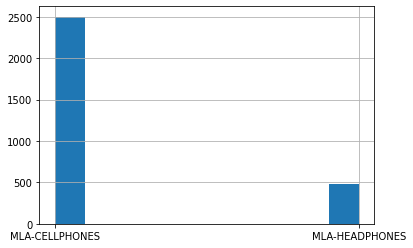

In [106]:
df.domain_id.hist()

In [107]:
df["domain_id"].replace({"MLA-CELLPHONES": 0, "MLA-HEADPHONES": 1}, inplace=True)

In [108]:
df.domain_id.unique()

array([0, 1])

In [20]:
df.to_csv('train.csv', index=False)

In [ ]:
"todos los perros comen carne"

In [ ]:
todos, los, perros, 

In [ ]:
todos los
los perros
perroos comen
comen carne

In [ ]:
todos los perros
los perros comen
perros comen carne